In [2]:
import pandas as pd
import nltk
import tensorflow as tf
import re
import numpy as np
import matplotlib.pyplot as plt

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 7.4 MB/s eta 0:00:00


In [5]:
import contractions

In [6]:
data=pd.read_csv("/content/drive/MyDrive/AI/Spam_SMS.csv")

In [7]:
def remove_stopwords(text_tokens):
  """
  This function removes all the stopwords present in out text tokens.
  Input Args:
  text_tokens: tokenize input of our datasets.
  Returns:
  result_tokens: list of token without stopword.
  """

  result_tokens = []
  for token in text_tokens:
    if token not in stop_words:
       result_tokens.append(token)
  return result_tokens

In [8]:
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize,pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def lemmatization(token_text):
  """
  This function performs the lemmatization operations as explained above.
  Input Args:
  token_text: list of tokens.
  Returns:
  lemmatized_tokens: list of lemmatized tokens.
  """
  lemma_tokens = []
  wordnet = WordNetLemmatizer()
  lemmatized_tokens = [wordnet.lemmatize(token, pos = 'v') for token in token_text]
  return lemmatized_tokens


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [9]:
def text_cleaning_pipeline(dataset):
  """
  This...
  """
  # Convert the input to small/lower order.
  data =dataset.lower()
  # Remove URLs
  data = re.sub(r'http\S+', '', data)
  # Remove emojis
  data =  re.sub(re.compile("["
                                                u"\U0001F600-\U0001F64F"  # emoticons
                                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                                u"\U00002702-\U000027B0"
                                                u"\U000024C2-\U0001F251"
                                                "]+", flags=re.UNICODE), r' ', data)
  # Remove mentions
  data =  re.sub(r'@\w+', '', data)
  # Remove all other unwanted characters.
  data = re.sub(r"#[\w]+|[^0-9A-Za-z ]", "", data)
  # Create tokens.
  tokens = data.split()
  # Remove stopwords:
  tokens = (remove_stopwords(tokens))
  # Handle contractions
  tokens = contractions.fix(tokens)
  # Lemmatize
  tokens =lemmatization(tokens)


  return " ".join(tokens)

In [10]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
data['Class']= label_encoder.fit_transform(data['Class'])

In [11]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data['Message'],data['Class'],test_size=0.2,random_state=42)

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
# Create a tokenizer instance
tokenizer = Tokenizer(num_words=80)

# Fit the tokenizer on the training text data
tokenizer.fit_on_texts(x_train)
# Convert training and testing text to sequences of integers
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
seq_lengths = [len(seq) for seq in train_sequences]
max_len = int(np.percentile(seq_lengths, 95))
# Pad sequences to ensure uniform length
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_len,truncating='post')
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_len,truncating='post')

In [14]:
from keras.models import Sequential
from keras.layers import Embedding,SimpleRNN,Dense
rnn_model=Sequential()
rnn_model.add(Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=128,input_length=max_len))
rnn_model.add(SimpleRNN(64))
rnn_model.add(Dense(1,activation='sigmoid'))
rnn_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
rnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
from keras.layers import LSTM
lstm_model=Sequential()
#OI FUCHE REMOVE THIS EMBEDDING LAYER AND ADD WORD2VEC
lstm_model.add(Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=128,input_length=max_len))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1,activation='sigmoid'))
lstm_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
history_rnn=rnn_model.fit(train_padded,y_train,epochs=10,validation_data=(test_padded,y_test))

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9008 - loss: 0.3095 - val_accuracy: 0.9543 - val_loss: 0.1503
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9512 - loss: 0.1514 - val_accuracy: 0.9202 - val_loss: 0.2062
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9537 - loss: 0.1380 - val_accuracy: 0.9587 - val_loss: 0.1281
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9676 - loss: 0.1109 - val_accuracy: 0.9534 - val_loss: 0.1293
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9684 - loss: 0.1031 - val_accuracy: 0.9480 - val_loss: 0.1658
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9750 - loss: 0.0815 - val_accuracy: 0.9578 - val_loss: 0.1325
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9783 - loss: 0.0742 - val_accuracy: 0.9543 - val_loss: 0.1432
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9758 - loss: 0.0678 - val_accu

In [17]:
rnn_model.evaluate(test_padded,y_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9608 - loss: 0.1349


[0.12923239171504974, 0.9596412777900696]

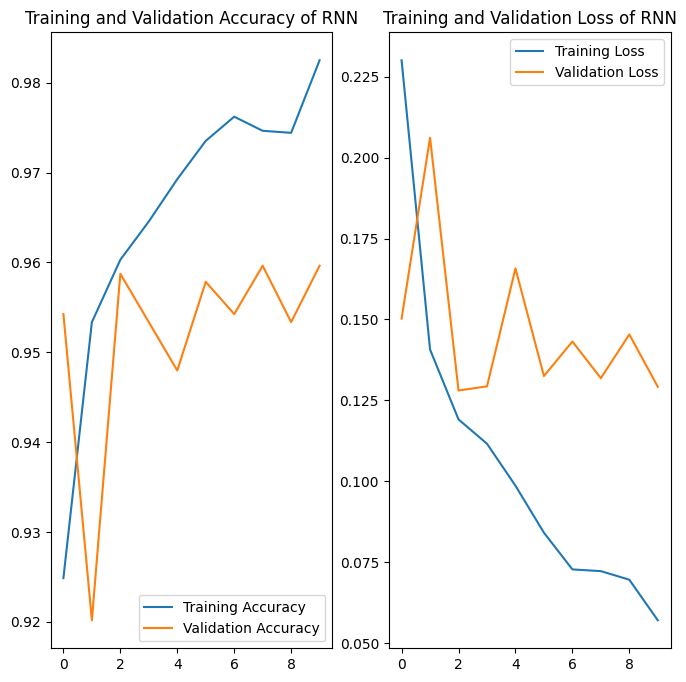

In [18]:
acc = history_rnn.history['accuracy']
val_acc = history_rnn.history['val_accuracy']

loss = history_rnn.history['loss']
val_loss = history_rnn.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy of RNN')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss of RNN')
plt.show()

In [19]:
history_lstm=lstm_model.fit(train_padded,y_train,epochs=10,validation_data=(test_padded,y_test))

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8652 - loss: 0.3740 - val_accuracy: 0.9453 - val_loss: 0.1614
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9567 - loss: 0.1332 - val_accuracy: 0.9587 - val_loss: 0.1233
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9587 - loss: 0.1317 - val_accuracy: 0.9587 - val_loss: 0.1215
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9585 - loss: 0.1277 - val_accuracy: 0.9587 - val_loss: 0.1201
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9637 - loss: 0.1213 - val_accuracy: 0.9570 - val_loss: 0.1175
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.9624 - loss: 0.1129 - val_accuracy: 0.9614 - val_loss: 0.1149
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.9687 - loss: 0.0982 - val_accuracy: 0.9561 - val_loss: 0.1310
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9609 - loss: 0.1130 - val_accu

In [20]:
lstm_model.evaluate(test_padded,y_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9634 - loss: 0.1304


[0.11010130494832993, 0.9686098694801331]

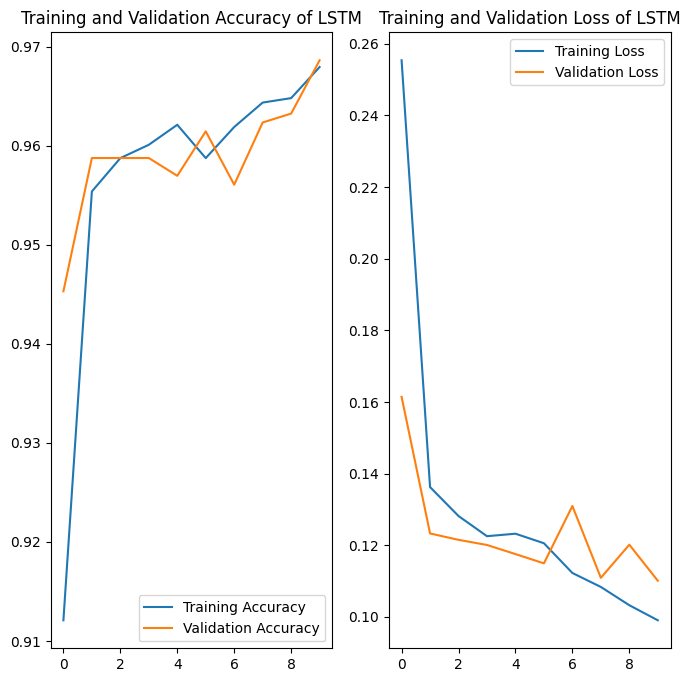

In [21]:
acc = history_lstm.history['accuracy']
val_acc = history_lstm.history['val_accuracy']

loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy of LSTM')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss of LSTM')
plt.show()